In [33]:
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# unzip file

import zipfile

with zipfile.ZipFile('datasets/twitter.zip') as zip_ref:
    zip_ref.extractall('datasets/twitter')

In [4]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('datasets/twitter//training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.shape

(1600000, 6)

In [8]:
# find nulls

df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [9]:
df['target']

0          0
1          0
2          0
3          0
4          0
          ..
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: target, Length: 1600000, dtype: int64

In [10]:
df['target'].unique()

array([0, 4], dtype=int64)

In [11]:
df['target'].nunique()

2

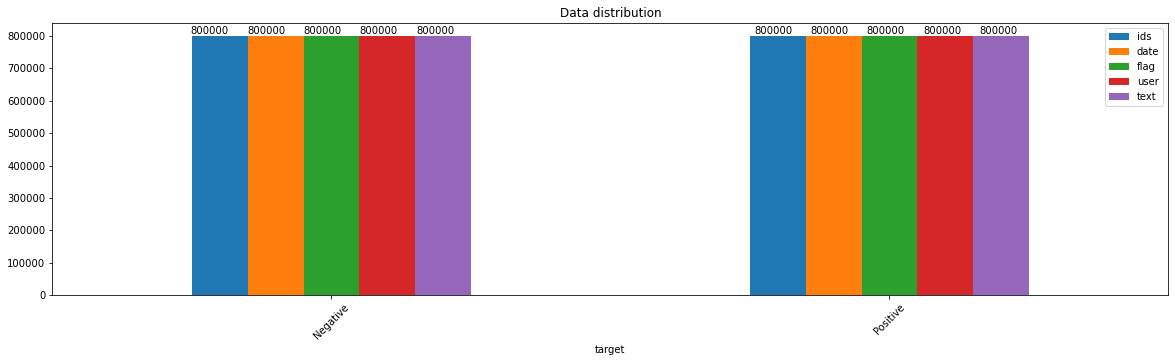

In [12]:
# plot data distribution

ax = df.groupby('target').count().plot(kind='bar', title='Data distribution', legend=True, figsize=(20, 5))

ax.set_xticklabels(['Negative','Positive'], rotation=45)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
    
# store the data in list
text, sentiments = list(df['text']), list(df['target'])


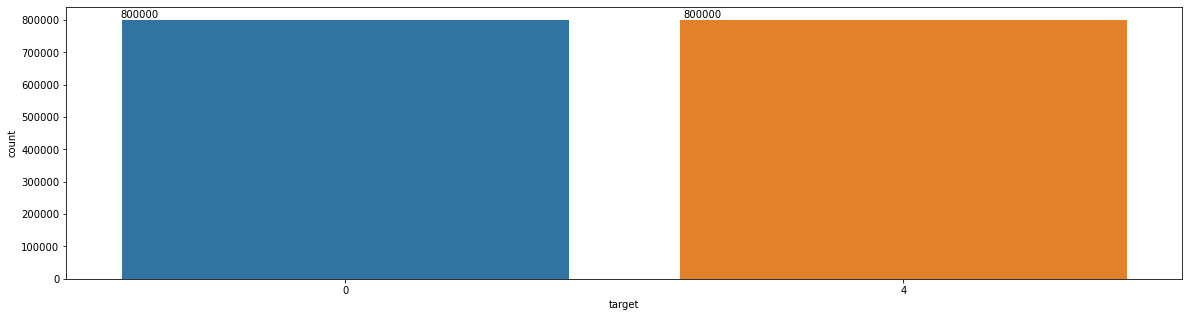

In [13]:
plt.figure(figsize = (20,5))
ax=sns.countplot(x='target', data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

In [14]:
data=df[['text','target']]
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [16]:
# Replacing 4 by 1 for understanding

data['target'] = data['target'].replace(4, 1)

<ipython-input-16-3faf30a0a008>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4, 1)


In [17]:
data['target'].unique()

array([0, 1], dtype=int64)

In [18]:
pos_data = data[data['target'] == 1]

In [19]:
pos_data.head()

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [20]:
neg_data = data[data['target'] == 0]

In [21]:
neg_data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [22]:
pos_data = pos_data.iloc[:int(20000)]
neg_data = neg_data.iloc[:int(20000)]

In [23]:
pos_data

,text,target
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
...,...,...
819995,We just met some awesome people at T.G.I Fridays,1
819996,oh my goodness . my feet are the most sensitiv...,1
819997,@hey_angy hahaha,1
819998,@Lamartian30 Pfft school is koo. I'm ranked 2n...,1


In [24]:
# convert to lowercase
pos_data.loc[:, 'text'] = pos_data.loc[:, 'text'].str.lower()

# remove tag
pos_data.loc[:, 'text'] = pos_data.loc[:, 'text'].apply(lambda x: re.sub(r'@\S+', "", x))

# remove punctuations
pos_data.loc[:, 'text'] = pos_data.loc[:, 'text'].apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word not in string.punctuation]))

# remove stop words

wordnet = WordNetLemmatizer()

pos_data.loc[:, 'text'] = pos_data.loc[:, 'text'].apply(lambda x: " ".join([wordnet.lemmatize(word, 'v') for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

In [25]:
pos_data

,text,target
800000,love u guy r best,1
800001,im meet one besties tonight cant wait girl talk,1
800002,thank twitter add sunisa get meet hin show dc ...,1
800003,sick really cheap hurt much eat real food plus...,1
800004,effect everyone,1
...,...,...
819995,meet awesome people t.g.i fridays,1
819996,oh goodness feet sensitive part body shit feel...,1
819997,hahaha,1
819998,pfft school koo 'm rank 2nd experimental psych...,1


In [26]:
# convert to lowercase
neg_data.loc[:, 'text'] = neg_data.loc[:, 'text'].str.lower()

# remove tag
neg_data.loc[:, 'text'] = neg_data.loc[:, 'text'].apply(lambda x: re.sub(r'@\S+', "", x))

# remove punctuations
neg_data.loc[:, 'text'] = neg_data.loc[:, 'text'].apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word not in string.punctuation]))

# remove stop words

wordnet = WordNetLemmatizer()

neg_data.loc[:, 'text'] = neg_data.loc[:, 'text'].apply(lambda x: " ".join([wordnet.lemmatize(word, 'v') for word in nltk.word_tokenize(x) if word not in stopwords.words('english')]))

In [37]:
final_data = pd.concat([pos_data, neg_data])
final_data

,text,target
800000,love u guy r best,1
800001,im meet one besties tonight cant wait girl talk,1
800002,thank twitter add sunisa get meet hin show dc ...,1
800003,sick really cheap hurt much eat real food plus...,1
800004,effect everyone,1
...,...,...
19995,much time weekend work trip malmï¿½ fri-sat to...,0
19996,one day holiday,0
19997,feel right .. hate damn humprey,0
19998,geez hv read whole book personality type embar...,0


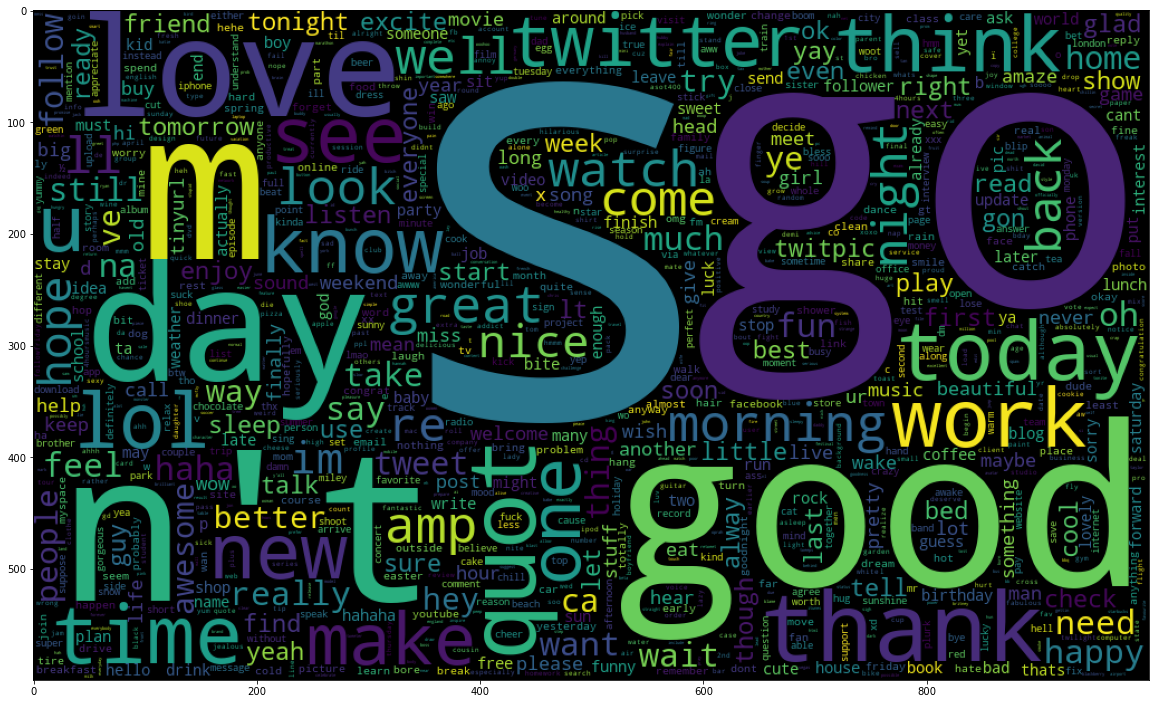

In [41]:
# plot data

plt.figure(figsize=(20, 20))
pos_wc = WordCloud(max_words=1000, width=1000, height=600, collocations=False).generate(" ".join(pos_data['text']))
plt.imshow(pos_wc)

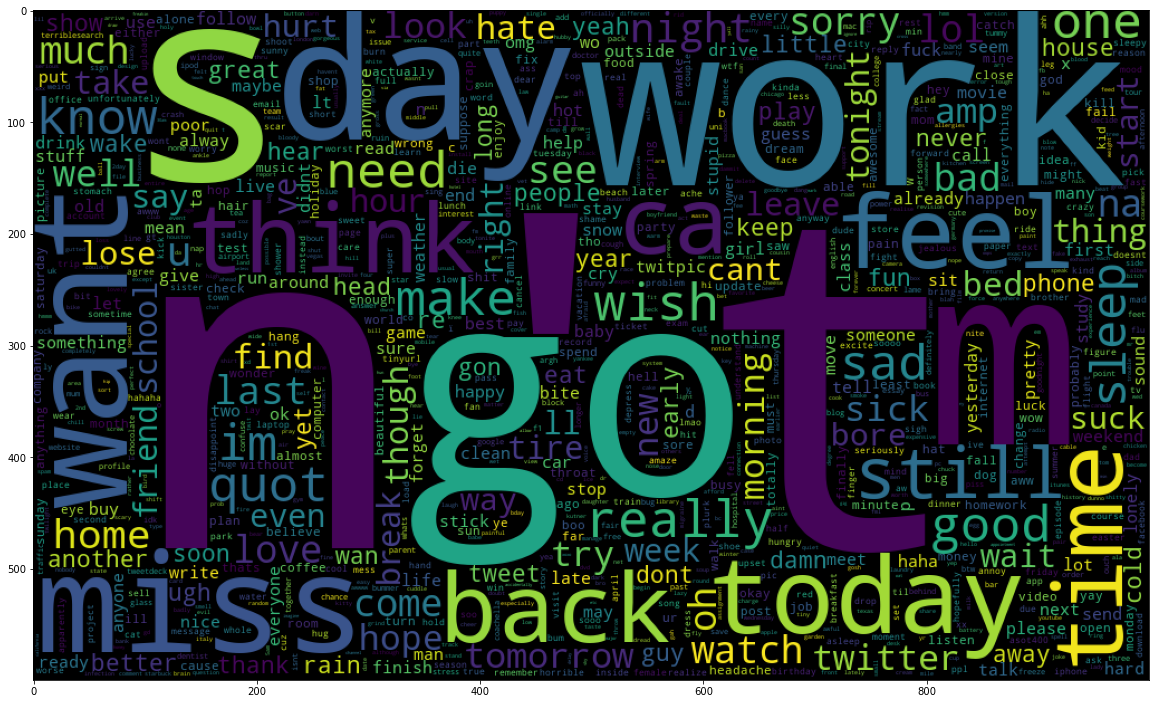

In [43]:
plt.figure(figsize=(20, 20))
neg_wc = WordCloud(max_words=1000, width=1000, height=600, collocations=False).generate(" ".join(neg_data['text']))
plt.imshow(neg_wc)

In [48]:
X = final_data.text
y = final_data.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =102)

In [49]:
# For reading purpose
train_data = pd.DataFrame({'text': X_train, 'target':y_train})
test_data = pd.DataFrame({'text': X_test, 'target': y_test})

In [58]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'(?u)\b[A-Za-z]+\b', 
    ngram_range=(1, 1),
    max_features=30000)
# train_vector = vectorizer.fit_transform(train_data['text'])
# test_vector = vectorizer.transform(test_data['text'])

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

In [52]:
print('No. of features : {}'.format(len(vectorizer.get_feature_names())))

No. of features : 22826


In [59]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      3954
           1       0.74      0.72      0.73      4046

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



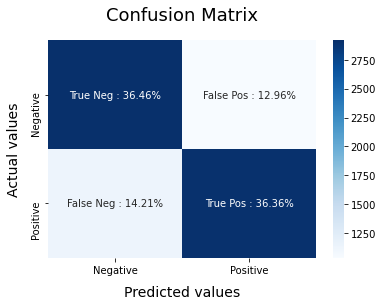

In [60]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

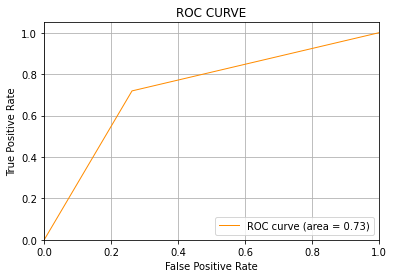

In [61]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.grid()

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3954
           1       0.72      0.73      0.73      4046

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.72      8000
weighted avg       0.72      0.72      0.72      8000



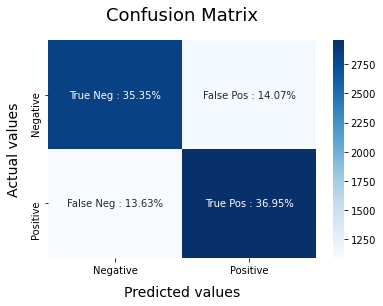

In [62]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

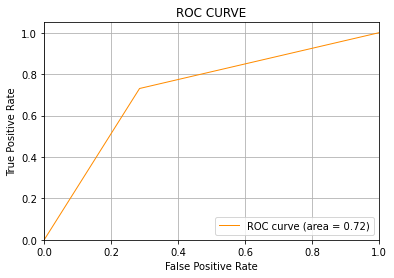

In [63]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.grid()

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      3954
           1       0.74      0.76      0.75      4046

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000



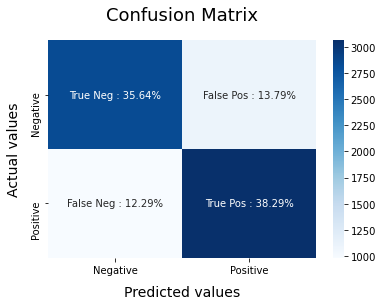

In [64]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

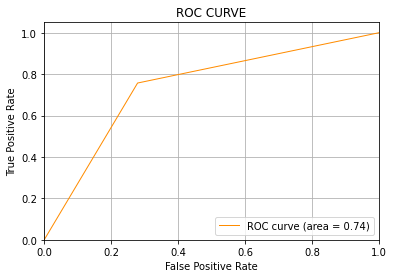

In [65]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.grid()